# การทำนายลักษณะกลุ่มโรคของพืช โดยใช้ Plant Disease Model

ตัวอย่างนี้จะเป็นการทำนายลักษณะกลุ่มโรคของพืช (Plant Disease) จากรูปภาพใบไม้ โดยใช้โครงสร้างโมเดลแบบ CNN ซึ่งจากโมเดลที่พัฒนาขึ้น ทำให้เราสามารถกำหนดตำแหน่งจุดที่สำคัญบนรูปภาพ เพื่อใช้ในการทำนายลักษณะกลุ่มโรคของพืช
ซึ่งเครื่องมือจากโมเดลดังกล่าวนี้ สามารถทำนายลักษณะของกลุ่มโรคในพืชแต่ละชนิดได้ทั้งหมด 39 รูปแบบ โดยแต่ละท่าทางที่ทำนายได้

<br>

ซึ่งขั้นตอนการนำภาพถ่ายมาผ่านโปรแกรมทำนายลักษณะกลุ่มโรคของพืชได้สรุปเอาไว้ 5 ขั้นตอน ดังนี้
<br><br>
![plant_workflow.jpg](https://raw.github.com/hengkp/microbit_ml_examples/main/plant%20disease%20prediction/plant_workflow.jpg)
<br><br>

โดยมีรายละเอียดพร้อมตัวอย่างโค้ดในขั้นตอนต่าง ๆ คือ<br>
**ขั้นตอนที่ 1** เตรียมข้อมูลสำหรับเทรนโมเดล<br>
**ขั้นตอนที่ 2** เตรียมชุดรูปภาพสำหรับเทรนโมเดล<br>
**ขั้นตอนที่ 3** นำเข้าและเตรียมโมเดล<br>
**ขั้นตอนที่ 4** เทรนโมเดลด้วยชุดรูปภาพที่เตรียมไว้<br>
**ขั้นตอนที่ 5** ทำนายลักษณะกลุ่มโรคของพืชผ่านโมเดลที่เตรียมไว้้<br>
**ขั้นตอนที่ 6** แสดงผลการทำนายลักษณะกลุ่มโรคของพืชจากรูปใบไม้<br>

In [3]:
#@title **ขั้นตอนที่ 1** เตรียมข้อมูลสำหรับเทรนโมเดล
#@markdown เป็นขั้นตอนการดาวน์โหลดชุดข้อมูลสำหรับนำมาใช้ในการเทรนโมเดล
#@markdown สามารถกดรันเพื่อดาวน์โหลดโฟลเดอร์ **Plant Leaf Disease Dataset** และ **plant_disease_model.h5**


# ดาวน์โหลดไฟล์โมเดล
%%shell
git clone https://github.com/hengkp/microbit_ml_examples.git

function getfile {
    cp -R "microbit_ml_examples/plant disease prediction/$1" "$1"
}

getfile "Plant Leaf Disease Dataset.zip"
getfile plant_disease_model.h5
rm -rf microbit_ml_examples

Cloning into 'microbit_ml_examples'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 146 (delta 2), reused 1 (delta 1), pack-reused 143
Receiving objects: 100% (146/146), 54.91 MiB | 14.07 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [4]:
#@title **ขั้นตอนที่ 2** เตรียมชุดรูปภาพสำหรับเทรนโมเดล
#@markdown เป็นขั้นตอนการนำเข้าและจัดเรียงรูปตามกลุ่มเพื่อใช้สำหรับการเทรนโมเดล

import os
import shutil
import urllib.request
import zipfile
import tensorflow as tf

# ฟังก์ชั่นสำหรับแตกไฟล์ ZIP
def extract_zip(filepath):
  with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall()

# ฟังก์ชั่นสำหรับลบโฟลเดอร์
def remove_folder(path):
    shutil.rmtree(path)

# ฟังก์ชั่นสำหรับลบไฟล์
def remove_file(file_path):
    os.remove(file_path)

# แตกไฟล์ชุดข้อมูล ZIP
filename = 'Plant Leaf Disease Dataset.zip'
extract_zip(filename)
remove_file(filename)

# กำหนดชื่อของแต่ละกลุ่ม
folder_name = os.path.splitext(filename)[0]
class_names = os.listdir(folder_name)
num_classes = len(class_names)

# กำหนดขนาดรูป
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

# กำหนดค่าการรันเทรนโมเดล
batch_size = 32
epochs = 5

# เตรียมชุดข้อมูล
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

# นำภาพที่ต้องการมาใส่ในชุดข้อมูลที่เตรียมไว้
train_dataset = data_gen.flow_from_directory(directory=folder_name,
                                             target_size=target_size,
                                             batch_size=batch_size,
                                             class_mode='categorical',
                                             classes=class_names)

train_dataset

Found 1200 images belonging to 5 classes.


In [5]:
#@title **ขั้นตอนที่ 3** นำเข้าและเตรียมโมเดล
#@markdown เขียนโมเดลสำหรับการทำนายลักษณะกลุ่มโรคของพืชจากรูปใบไม้โดยใช้โมเดลเริ่มต้น ImageNet V2 และปรับแต่งผลลัพธ์เพื่อให้สามารถจำแนกกลุ่มของโรคได้

import os
import tensorflow as tf

# เตรียมโมเดลพื้นฐาน
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# ตั้งค่าโมเดลพื้นฐานไม่ให้สามารถเปลี่ยนแปลงได้
for layer in base_model.layers:
    layer.trainable = False

# ปรับแต่งโมเดลโดยเพิ่มขั้นตอนการแยกกลุ่ม เพื่อให้ได้ผลลัพท์ตามจำนวนที่กำหนด
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# กำหนดค่าฟังก์ชั่นที่จำเป็นต่อการเทรนโมเดล
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_____________________________________________

In [6]:
#@title **ขั้นตอนที่ 4** เทรนโมเดลด้วยชุดรูปภาพที่เตรียมไว้
#@markdown กดรันเพื่อเริ่มการเทรนโมเดล โดยขั้นตอนนี้จะใช้เวลานานเพื่อประมวลผลเนื่องจากปริมาณของรูปที่ใช้มีจำนวนมาก <br>
#@markdown ผู้เรียนสามารถข้ามขั้นตอนนี้ได้ โดยกดรันขั้นตอนต่อไปแทน ซึ่งเป็นขั้นตอนการนำเข้าโมเดลที่ผ่านการเทรนแล้วมาจากอินเตอร์เน็ต

history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=len(train_dataset),
                    verbose=2)

# บันทึกโมเดลที่ผ่านการเทรนแล้ว
model.save('plant_disease_model.h5')

Epoch 1/5
38/38 - 53s - loss: 0.8843 - accuracy: 0.6683 - 53s/epoch - 1s/step
Epoch 2/5
38/38 - 50s - loss: 0.2931 - accuracy: 0.9225 - 50s/epoch - 1s/step
Epoch 3/5
38/38 - 51s - loss: 0.1982 - accuracy: 0.9417 - 51s/epoch - 1s/step
Epoch 4/5
38/38 - 52s - loss: 0.1416 - accuracy: 0.9642 - 52s/epoch - 1s/step
Epoch 5/5
38/38 - 51s - loss: 0.1151 - accuracy: 0.9750 - 51s/epoch - 1s/step


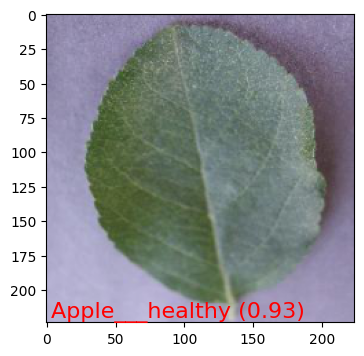

In [11]:
#@title **ขั้นตอนที่ 5** ทำนายลักษณะกลุ่มโรคของพืชผ่านโมเดลที่เตรียมไว้
#@markdown กดรันเพื่อนำเข้ารูปตัวอย่างที่ต้องการทำนายผลและทำนายผล

from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage import io

# นำเข้าโมเดล
model = tf.keras.models.load_model('plant_disease_model.h5')

# ใส่ที่อยู่ของภาพที่ต้องการนำเข้า
image_path = "Plant Leaf Disease Dataset/Apple___healthy/image (1).JPG"

# นำเข้าและปรับขนาดภาพให้สอดคล้องกับความต้องการของโมเดล
img = io.imread(image_path)
img = cv2.resize(img, target_size) # resize to match inputs of model

# ปรับลักษณะของรูปให้สอดคล้องกับความต้องการของโมเดล
img_input = img / 255.0
img_input = np.expand_dims(img_input, axis=0)

# ประมวลผลภาพ
prediction = model.predict(img_input, verbose=0)

# ดึงข้อมูลพิกัดที่สำคัญที่ได้จากผลการประมวล
class_index = np.argmax(prediction[0])
class_name = list(class_names)[class_index]

# เตรียมรูปภาพเพื่อแสดงผล
if np.max(img) <= 1:
    img = (img * 255).astype(np.uint8) # convert image back to [0..255] format
fig, ax = plt.subplots(figsize=(4, 4)) # define size of figure

# ใส่รูปภาพ
plt.imshow(img)

# ใส่ชื่อวัตถุลงในภาพ
text = class_name + " ({:.2f})".format(prediction[0][class_index])
ax.annotate(text, (3, 220), fontsize=16, color="red")

# แสดงผลรูปภาพพร้อมพิกัด
plt.show()

In [12]:
#@title **ขั้นตอนที่ 6** แสดงผลการทำนายลักษณะกลุ่มโรคของพืชจากรูปใบไม้
#@markdown กดรันเพื่อแสดงผลการทำนาย

# แสดงผลชื่อกลุ่มของวัตถุนั้น
text = class_name + " ({:.2f})".format(prediction[0][class_index])
print("Predicted Class:", text)

Predicted Class: Apple___healthy (0.93)
